In [2]:
import matplotlib.pyplot as plt

import numpy as np
import numpy.random as npr
import torch
import ot
import os
import shutil

from IPython.display import Image

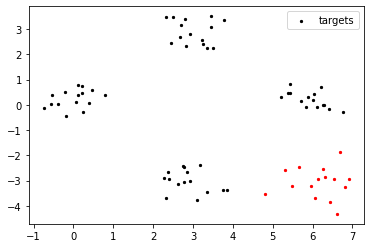

In [3]:
n = 15

mu_w = np.array([3, -3])
cov_w = np.array([[1, 0], [0, 1]])*0.2

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])*0.2

mu_t = np.array([6, 0])
cov_t = np.array([[1, 0], [0, 1]])*0.2

mu_u = np.array([3, 3])
cov_u = np.array([[1, 0], [0, 1]])*0.2

mu_b = np.array([6, -3])
cov_b = np.array([[1, 0], [0, 1]])*0.2

w = ot.datasets.make_2D_samples_gauss(n, mu_w, cov_w)
x = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
y = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
z = ot.datasets.make_2D_samples_gauss(n, mu_u, cov_u)
b = ot.datasets.make_2D_samples_gauss(n, mu_b, cov_b)

w_th = torch.from_numpy(w).float().requires_grad_()
x_th = torch.from_numpy(x).float().requires_grad_()
y_th = torch.from_numpy(y).float().requires_grad_()
z_th = torch.from_numpy(z).float().requires_grad_()
b_th = torch.from_numpy(b).float().requires_grad_()

def plot(w, x, y, z, b, save=None, close=False):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(w.detach()[:,0], w.detach()[:,1], s=5, c='black', label='targets')
    ax.scatter(x.detach()[:,0], x.detach()[:,1], s=5, c='black')
    ax.scatter(y.detach()[:,0], y.detach()[:,1], s=5, c='black')
    ax.scatter(z.detach()[:,0], z.detach()[:,1], s=5, c='black')
    ax.scatter(b.detach()[:,0], b.detach()[:,1], s=5, c='red')
    
    plt.legend()
    
    if save is not None:
        fig.savefig(save)
    if close:
        plt.close(fig)
        
        
plot(w_th, x_th, y_th, z_th, b_th)

In [4]:
def W1(x, y):
    assert x.ndim == 1 and y.ndim == 1
    x_sort, _ = torch.sort(x)
    y_sort, _ = torch.sort(y)
    return (x_sort - y_sort).pow(2).mean()

def SW(x, y, n_projections=2000):
    thetas = torch.randn(n_projections, 2)
    thetas = thetas/thetas.norm(dim=1, keepdim=True)
    # TODO: Could be optimized
    Ws = []
    for i in range(n_projections):
        x1 = x.mv(thetas[i])
        y1 = y.mv(thetas[i])
        Ws.append(W1(x1, y1))
    res = sum(Ws)/n_projections
    res = res ** .5
    return res

def SMW(w, x, y, z, b, n_projections=30):
    return  SW(w, b, n_projections=n_projections) + SW(x, b, n_projections=n_projections) + \
            SW(y, b, n_projections=n_projections) + SW(z, b, n_projections=n_projections) 



In [5]:
d = SMW(w_th, x_th, y_th, z_th, b_th)
d_grad = torch.autograd.grad(d, x_th)
print(d)

tensor(14.7713, grad_fn=<AddBackward0>)


Text(0, 0.5, '$\\mathcal{SMW}$ (up to constants)')

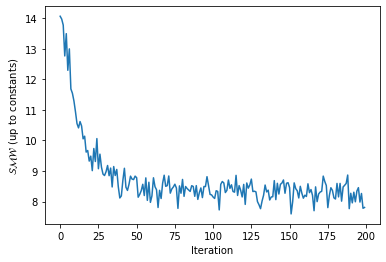

In [6]:
bt_th = b_th.clone().detach().requires_grad_()
opt = torch.optim.SGD([bt_th], lr=1.)

shutil.rmtree('tmp')
os.makedirs('tmp', exist_ok=True)
ds = []
bts = []
for t in range(200):
    bts.append(bt_th.clone())
    d = SMW(w_th, x_th, y_th, z_th, bt_th)
    opt.zero_grad()
    d.backward()
    ds.append(d.item())
    opt.step()
    plot(w_th, x_th, y_th, z_th, bt_th, save=f'tmp/{t:03d}.png', close=True)
    
bts = torch.stack(bts)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ds)
ax.set_xlabel('Iteration')
ax.set_ylabel('$\mathcal{SMW}$ (up to constants)')

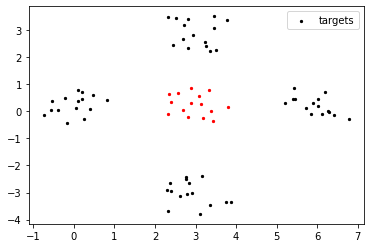

In [7]:
plot(w_th, x_th, y_th, z_th, bt_th,)

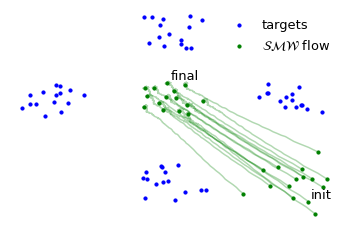

In [10]:

fig, ax = plt.subplots(1, 1)
for i in range(n):
    ax.plot(bts[:,i,0].detach(), bts[:,i,1].detach(), color='green', alpha=0.3)

s =10
ax.scatter(w[:,0], w[:,1], s=s, c='blue', label='targets')
ax.scatter(x[:,0], x[:,1], s=s, c='blue')
ax.scatter(y[:,0], y[:,1], s=s, c='blue')
ax.scatter(z[:,0], z[:,1], s=s, c='blue')
ax.scatter(bts.detach()[0,:,0], bts.detach()[0,:,1], s=s, c='green', label='$\mathcal{SMW}$ flow')
ax.scatter(bt_th.detach()[:,0], bt_th.detach()[:,1], s=s, c='green')
ax.text(6.5, -3.7, 'init', fontsize=13)
ax.text(3, 1, 'final', fontsize=13)

plt.legend(frameon=False, fontsize=13)
plt.axis('off')

fig.savefig('2d_multi.pdf', transparent=True)